In [25]:
import sys
import os
from pathlib import Path

current_dir = Path(os.getcwd())
project_root = current_dir.parent
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from models.clustering.movie_clusterer import MovieClusterer
from models.clustering.clustering_movie_recommender import ClusteringMovieRecommender
from utils.movie_data_loader import load_clustering_data
from utils.movie_data_loader import MovieDataLoader

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Clustering Model Results

## 1. Data Loading

In [26]:
data = load_clustering_data()
print(f"Data loaded: {data.shape[0]} samples, {data.shape[1]} features")
display(data.head())

Data loaded: 10178 samples, 4 features


,year,score,budget_x,revenue
0,2023,73.0,75000000.0,2.716167e+08
1,2022,78.0,460000000.0,2.316795e+09
2,2023,76.0,100000000.0,7.244590e+08
3,2023,70.0,12300000.0,3.420000e+07
4,2023,61.0,77000000.0,3.409420e+08


## 2. Optimal Clusters Analysis (Elbow Method)

k=10: Silhouette Score = 0.4641
k=20: Silhouette Score = 0.3784
k=30: Silhouette Score = 0.4002
k=40: Silhouette Score = 0.3913
k=50: Silhouette Score = 0.3881


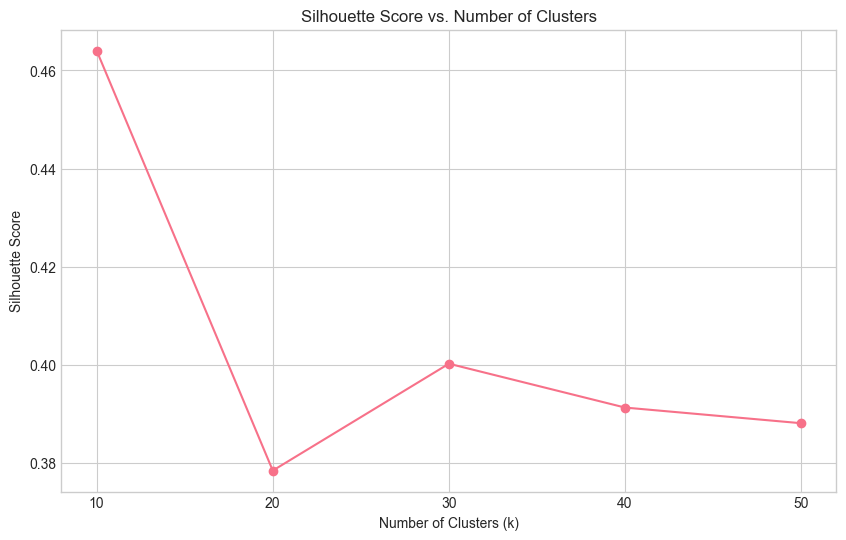

In [27]:
k_range = [10, 20, 30, 40, 50]
silhouette_scores = []

for k in k_range:
    temp_clusterer = MovieClusterer(data, number_of_clusters=k, random_state=42)
    temp_clusterer.fit()
    
    labels = temp_clusterer.cluster_assignation['cluster_id']
    score = silhouette_score(data, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## 3. Model Training

In [28]:
n_clusters = 30
print(f"Training Final MovieClusterer with k={n_clusters}...")
clusterer = MovieClusterer(data, number_of_clusters=n_clusters, random_state=42)
clusterer.fit()

Training Final MovieClusterer with k=30...


## 4. PCA Cluster Visualization (2D)

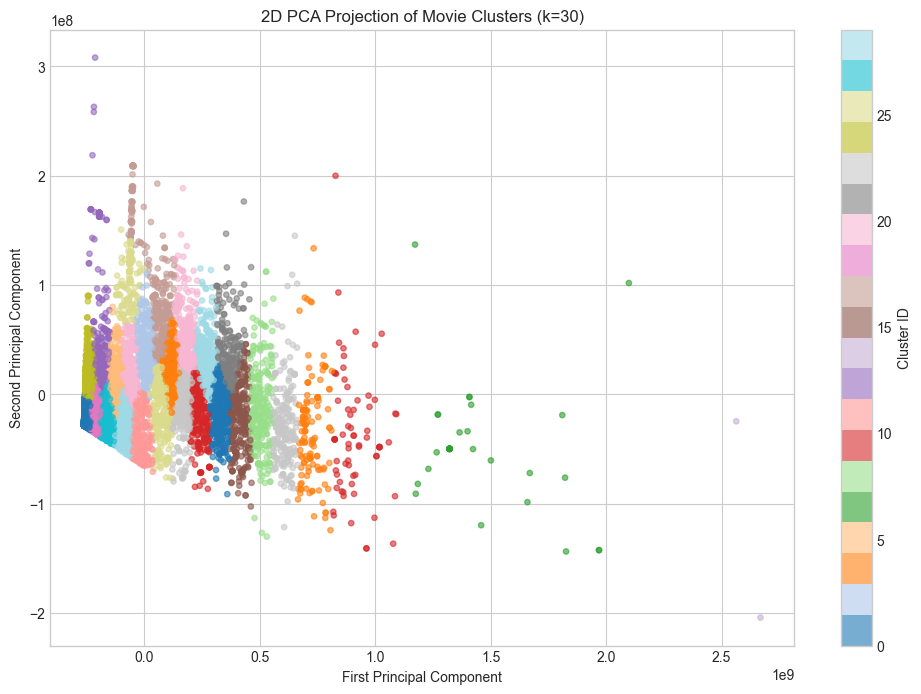

In [29]:
assignments = clusterer.cluster_assignation

pca = PCA(n_components=2, random_state=42)
pca_embedding = pca.fit_transform(data)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_embedding[:, 0],
    pca_embedding[:, 1],
    c=assignments['cluster_id'],
    cmap='tab20',
    alpha=0.6,
    s=15
)
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'2D PCA Projection of Movie Clusters (k={n_clusters})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

## 5. Results Analysis

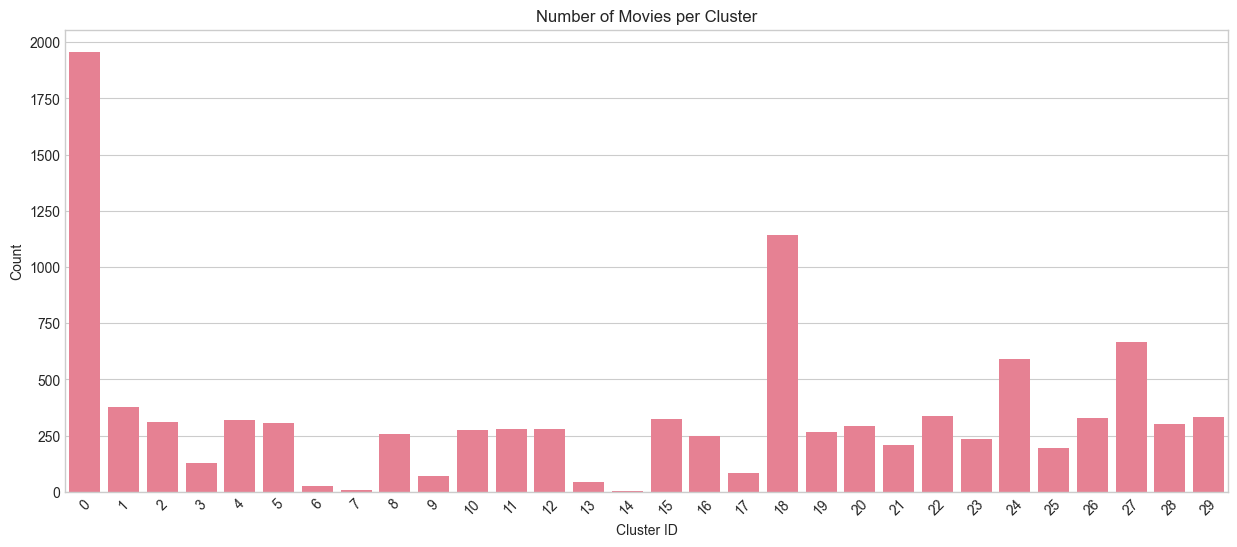

In [30]:
cluster_counts = assignments['cluster_id'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 6. Recommendation Testing

In [31]:
def score_and_print_recommendations(reference_ids: list[int], model):
    recommender = ClusteringMovieRecommender(model=model)
    assignations = recommender.assignations

    loader = MovieDataLoader()
    clean_df = loader.get_clean_data()

    scores = recommender.recommend_movies(reference_ids)

    columns = ["names", "year", "score", "budget_x", "revenue"]
    results = assignations[["cluster_id"]].join(clean_df[columns], how="left")
    results["recommendation_score"] = scores

    all_cols = ["recommendation_score", "cluster_id"] + columns

    ref_rows = results.loc[reference_ids]
    print("\n--- Reference movies ---")
    display(ref_rows[["cluster_id"] + columns])

    non_ref = results.loc[~results.index.isin(reference_ids)]
    top10 = non_ref.sort_values("recommendation_score", ascending=False).head(10)

    print("\n--- Top 10 recommendations ---")
    display(top10[all_cols])

In [32]:
print("Test with 3 different clusters:")
score_and_print_recommendations([0, 1, 2], clusterer)

Test with 3 different clusters:

--- Reference movies ---


,cluster_id,names,year,score,budget_x,revenue
0,2,Creed III,2023,73.0,75000000.0,2.716167e+08
1,7,Avatar: The Way of Water,2022,78.0,460000000.0,2.316795e+09
2,8,The Super Mario Bros. Movie,2023,76.0,100000000.0,7.244590e+08



--- Top 10 recommendations ---


,recommendation_score,cluster_id,names,year,score,budget_x,revenue
4045,32.721216,2,Winnie the Pooh: Springtime with Roo,2004,67.0,108000000.0,254948951.2
9596,32.675660,8,Crayon Shin-chan: Super-Dimension! The Storm C...,2010,81.0,124000000.0,752364323.2
2436,32.316726,2,Men in Black: International,2019,60.0,110000000.0,253015298.0
5761,32.047273,8,Wyrmwood: Road of the Dead,2015,61.0,117200000.0,755498891.0
5830,32.010206,8,The Knight of Shadows: Between Yin and Yang,2019,55.0,123000000.0,748580504.0
541,31.480359,2,"Goodbye, Don Glees!",2022,60.0,111000000.0,251309155.0
1000,31.063587,2,Jesús de Nazaret: El Hijo de Dios,2019,68.0,103800000.0,251678636.0
6487,30.922741,2,Sonic the Hedgehog: The Movie,1996,68.0,112400000.0,251358333.2
2785,30.886887,8,Togo,2019,82.0,117740000.0,762058691.2
7092,30.829913,2,Nekromantik,1988,52.0,103000000.0,252514495.2


In [33]:
print("Test with old movies:")
score_and_print_recommendations([87, 58, 22], clusterer)

Test with old movies:

--- Reference movies ---


,cluster_id,names,year,score,budget_x,revenue
87,24,Super Mario Bros.,1993,43.0,42000000.0,20844907.0
58,0,A Bronx Tale,1994,78.0,10000000.0,17287898.0
22,1,The Passion of the Christ,2004,74.0,25000000.0,622313635.0



--- Top 10 recommendations ---


,recommendation_score,cluster_id,names,year,score,budget_x,revenue
7689,32.978866,24,Not Without My Daughter,1991,66.0,45860000.0,14789113.0
8601,32.954287,1,K-ON! The Movie,2011,80.0,96400000.0,580287053.2
6536,32.810640,1,A Week Away,2021,69.0,97000000.0,580151910.0
9522,32.696757,0,Runaway Train,1986,70.0,9000000.0,7936012.0
9630,32.692588,0,The Omega Man,1971,62.0,8809746.0,8720000.0
8484,32.630699,24,Solaris,1972,79.0,47000000.0,14970038.0
8722,32.401296,24,The Bonfire of the Vanities,1990,56.0,47000000.0,15691192.0
8852,32.333530,0,Let Him Go,2021,69.0,8173967.0,7997460.0
1611,32.288008,0,Ong Bak 2,2008,64.0,8500000.0,8936663.0
2197,32.274746,24,The Interview,2015,62.0,44000000.0,12342632.0


In [34]:
print("Test with movies from same cluster:")
score_and_print_recommendations([14, 17, 20], clusterer)

Test with movies from same cluster:

--- Reference movies ---


,cluster_id,names,year,score,budget_x,revenue
14,10,The Pope's Exorcist,2023,72.0,92000000.0,462216471.8
17,10,The Devil Conspiracy,2023,65.0,54060000.0,492646395.4
20,10,The Magician's Elephant,2023,73.0,82600000.0,473097256.6



--- Top 10 recommendations ---


,recommendation_score,cluster_id,names,year,score,budget_x,revenue
6397,96.889359,10,Sunny Side Battle!,2014,58.0,76300000.0,493662105.2
1708,95.261789,10,Dangerous Game: The Legacy Murders,2022,76.0,75000000.0,494257951.8
4457,91.415339,10,Justice League: Crisis on Two Earths,2010,73.0,76000000.0,488364590.2
10091,90.808376,10,Love Match,2014,53.0,81050080.0,500686647.0
4161,90.734281,10,Cencoroll Connect,2019,70.0,73200000.0,498693699.0
9446,89.901204,10,Lola Índigo: La Niña,2022,72.0,71000000.0,493770790.6
3556,89.561805,10,Doraemon: Nobita and the Island of Miracles - ...,2012,70.0,82095400.0,501240695.4
6891,89.561805,10,SlugTerra: Return of the Elementals,2014,70.0,82095400.0,501240695.4
3464,88.794974,10,Justice League: Gods and Monsters,2015,72.0,84200000.0,488059774.2
2409,88.456410,10,The King of Staten Island,2020,70.0,78700000.0,485621788.4
